# Project 

This is the project for course EE4540 Distributed Signal Processing.

Environment:

Python = 3.12

## Initialization

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.colors import LinearSegmentedColormap
# import seaborn as sns
import time
import random
from math import log, pi, ceil
from scipy.optimize import fsolve

In [2]:
# 设置随机种子
np.random.seed(42)
random.seed(42)

## Q1

In [11]:
selection = input(" Do you like the communication radius fixed(option 1) or the number of sensors fixed(option 2)?")
if selection != "1" and selection != "2":
    print("Holy shit!")
else:
    print("")
    selection_2 = input("Do you want to check certain number of your choice(option 1) or you want to see a tendency(option 2)?")
    if selection_2 != "1" and selection_2 != "2":
        print("Holy shit again!")

if selection == "1":
    if selection_2 == "1":
        selection_final = 1
    else:
        selection_final = 2
elif selection_2 == "1":
    selection_final = 3
else:
    selection_final = 4
print(selection_final)


3


In [12]:
# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99


# Known r, calculate n
def nodes_for_coverage(area_size, Comm_Radius, coverage_required):
    return ceil(-area_size * np.log(1 - coverage_required) / (pi * Comm_Radius ** 2))


# Minimum amount of sensors according to RGG
def nodes_for_connectivity(normalized_radius, dimension, probability):
    def equation(n_array):
        '''This is the equation for RGG'''
        return (2 * np.log(n_array[0])) / n_array[0] - normalized_radius ** dimension

    n_array = [10.0]
    n_connectivity = fsolve(equation, n_array)  # Calculation the equation equals to 0, n_array is a start point
    # Consider the probability of connection
    n_prob = ceil(np.sqrt(1 / (1 - probability)))

    return max(int(ceil(n_connectivity[0])), n_prob)

def nodes_final (Comm_Radius):
    # Calculate number of nodes
    n_coverage = nodes_for_coverage(Area_Size, Comm_Radius, Area_Coverage)
    print(f"Minimum sensors required for coverage: {n_coverage}")
    n_connectivity = nodes_for_connectivity(Comm_Radius / Area_Length, dimension=2, probability=Connected_Prob)
    print(f"Minimum sensors required for connectivity: {n_connectivity}")

    n_final = max(n_connectivity, n_coverage)
    print(f"Final number of sensors used: {n_final}")
    # Random place the sensors
    # np.random.seed(42)
    sensor_location = np.random.uniform(0, Area_Length, (n_final, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(n_final):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(n_final):
        for k in range(j + 1, n_final):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    return(Graphs, n_final, sensor_location)

Minimum radius required for coverage: 141.4213562373095
Minimum radius of sensors required for connectivity: 141.4213562373095
Final radius of sensors used: 141.4213562373095
The graph is connected
Minimum radius required for coverage: 20.76387698808038
Minimum radius of sensors required for connectivity: 39.266937810197675
Final radius of sensors used: 39.266937810197675
The graph is connected
Minimum radius required for coverage: 14.754783740587769
Minimum radius of sensors required for connectivity: 30.230535073988605
Final radius of sensors used: 30.230535073988605
The graph is connected
Minimum radius required for coverage: 12.067159738241251
Minimum radius of sensors required for connectivity: 25.778680643839706
Final radius of sensors used: 25.778680643839706
The graph is connected
Minimum radius required for coverage: 10.459128690626134
Minimum radius of sensors required for connectivity: 22.971548285926318
Final radius of sensors used: 22.971548285926318
The graph is connected

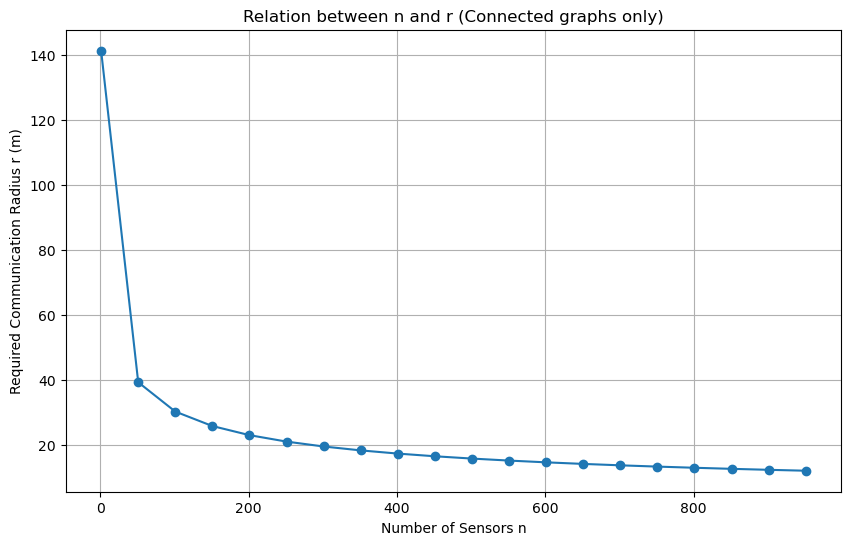

In [13]:
if selection_final == 1:
    # Circle for different r
    r_values = []
    n_values = []
    connected_count = 0
    disconnected_count = 0
    for Comm_Radius in range(5, 100, 1):

        Graphs, n_final,_ = nodes_final(Comm_Radius)
        # Check connectivity
        connection_state = nx.is_connected(Graphs)
        if connection_state:
            print("The graph is connected")
            connected_count += 1
            r_values.append(Comm_Radius)
            n_values.append(n_final)
        else:
            print("The graph is not connected")

    print(f"Connected graphs: {connected_count}")
    print(f"Disconnected graphs: {disconnected_count}")

    # Plot r vs n
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, n_values, marker='o')
    plt.xlabel("Communication Radius r (m)")
    plt.ylabel("Required Number of Sensors n")
    plt.yscale('log')
    plt.title("Relation between r and n (Connected graphs only)")
    plt.grid(True)
    plt.show()
if selection_final == 2:
    Comm_Radius = input("Please input the communication Radius r (m):")
    Graphs, n_final, sensor_location = nodes_final(int(Comm_Radius))
    connection_state = nx.is_connected(Graphs)
    if connection_state:
        print("The graph is connected")
    else:
        print("The graph is not connected")
    # Visualize the graph
    pos_dict = {i: sensor_location[i] for i in range(n_final)}
    plt.figure(figsize=(8, 8))
    nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
            node_color='skyblue', edge_color='gray')
    plt.title(f"Random Geometric Graph (Connected: {connection_state})")
    plt.grid(True)
    plt.xlim(0, Area_Length)
    plt.ylim(0, Area_Length)
    plt.show()


# Known n, calculate r

def radius_for_coverage(number_nodes):
    r_cov = np.sqrt(-Area_Size * log(1 - Area_Coverage) / (pi * number_nodes))
    maximum_radius = Area_Length * np.sqrt(2)
    if r_cov > maximum_radius:
        return maximum_radius
    else:
        return r_cov

def radius_for_connectivity(number_nodes):
    if (1 - 1/(number_nodes **2)) < Connected_Prob:
        maximum_radius = Area_Length * np.sqrt(2)
        return maximum_radius
    else:
        r_conn = Area_Length * np.sqrt(2 * log(number_nodes)/number_nodes)
        return r_conn

def radius_final(number_nodes):
    r_coverage = radius_for_coverage(number_nodes)
    print(f"Minimum radius required for coverage: {r_coverage}")
    r_connectivity = radius_for_connectivity(number_nodes)
    print(f"Minimum radius of sensors required for connectivity: {r_connectivity}")

    r_final = max(r_connectivity, r_coverage)
    print(f"Final radius of sensors used: {r_final}")
    # Random place the sensors
    # np.random.seed(42)
    sensor_location = np.random.uniform(0, Area_Length, (number_nodes, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= r_final) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(number_nodes):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(number_nodes):
        for k in range(j + 1, number_nodes):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    return(Graphs, r_final, sensor_location)


if selection_final == 3:
    # Circle for different n
    r_values = []
    n_values = []
    connected_count = 0
    disconnected_count = 0
    for number_nodes in range(1, 1000, 50):

        Graphs, r_final,_ = radius_final(number_nodes)
        # Check connectivity
        connection_state = nx.is_connected(Graphs)
        if connection_state:
            print("The graph is connected")
            connected_count += 1
            r_values.append(r_final)
            n_values.append(number_nodes)
        else:
            print("The graph is not connected")

    print(f"Connected graphs: {connected_count}")
    print(f"Disconnected graphs: {disconnected_count}")

    # Plot r vs n
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, r_values, marker='o')
    plt.xlabel("Number of Sensors n")
    plt.ylabel("Required Communication Radius r (m)")
    #plt.yscale('log')
    plt.title("Relation between n and r (Connected graphs only)")
    plt.grid(True)
    plt.show()

if selection_final == 4:
    number_nodes = input("Please input the number of sensors:")
    Graphs, r_final, sensor_location = radius_final(int(number_nodes))
    connection_state = nx.is_connected(Graphs)
    if connection_state:
        print("The graph is connected")
    else:
        print("The graph is not connected")
    # Visualize the graph
    pos_dict = {i: sensor_location[i] for i in range(int(number_nodes))}
    plt.figure(figsize=(8, 8))
    nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
            node_color='skyblue', edge_color='gray')
    plt.title(f"Random Geometric Graph (Connected: {connection_state})")
    plt.grid(True)
    plt.xlim(0, Area_Length)
    plt.ylim(0, Area_Length)
    plt.show()

## Generate nodes and edges for further processing
随机生成结点和相应联通边

n=120 r=30

In [3]:
# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99

In [4]:
n = 50                   # Number of sensors
Comm_Radius = 40          # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix[j,k]:
            Graphs.add_edge(j, k)
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

[[False False False ... False False False]
 [False False False ...  True  True False]
 [False False False ... False False  True]
 ...
 [False  True False ... False  True False]
 [False  True False ...  True False False]
 [False False  True ... False False False]]
Network connected: True
Number of edges: 395


In [5]:
# 初始值
init_values = np.random.uniform(20, 30, n)
global_avg = np.mean(init_values)
print(f"Global average: {global_avg:.4f}")


Global average: 24.7830


## Q2 Averaging
### randomised gossip

In [17]:
# 随机Gossip算法实现
def randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=5000, convergence_threshold=1e-6):
    """实现随机Gossip算法计算平均值"""
    # 全局平均值仅用于验证，实际分布式算法中不用

    values = init_values.copy()
    n = len(values)
    
    # 初始化历史记录
    history = {
        # 'node_values': [],
        # 'avg_estimates': [],
        'errors': [],
        'transmissions': 0,
        'iteration': 0
    }
    
    # 初始状态
    # history['node_values'].append(np.array([graph.nodes[i]['value'] for i in graph.nodes]))
    # history['avg_estimates'].append(np.mean(np.array([graph.nodes[i]['avg_value'] for i in graph.nodes])))
    history['errors'].append(np.sum((values - global_avg) ** 2))
    
    iteration = 0
    
    while iteration < max_iterations:
        # 随机选择一个节点
        node_i = random.randint(0, n - 1)
        
        # 随机选择一个邻居
        neighbors = [idx for idx, connected in enumerate(adj_matrix[node_i]) if connected]
        if not neighbors:
            continue
        node_j = random.choice(neighbors)
        
        # 交换值并更新
        value_i = values[node_i]
        value_j = values[node_j]
        
        # 计算平均值
        new_value = (value_i + value_j) / 2.0
        
        # 更新两个节点的值
        values[node_i] = new_value
        values[node_j] = new_value
        
        # 记录传输次数
        history['transmissions'] += 2  # 双向通信

        iteration += 1
        
        # 记录当前状态
        if iteration % 10 == 0:  # 每10次迭代记录一次
            # current_values = np.array([graph.nodes[i]['avg_value'] for i in graph.nodes])
            # history['node_values'].append(current_values.copy())
            # history['avg_estimates'].append(np.mean(current_values))
            current_error = np.sum((values - global_avg) ** 2)
            history['errors'].append(current_error)
            
            # 检查收敛
            if current_error < convergence_threshold:
                break
    
    history['iteration'] = iteration

    return values, history



In [18]:
# 运行随机Gossip算法
print("\nRunning randomised gossip algorithm...")
start_time = time.time()
final_rg, history_rg = randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=3000)
elapsed_time = time.time() - start_time

# 输出结果
final_values = final_rg
final_avg = np.mean(final_values)
final_error = history_rg['errors'][-1]  # 最后一次记录的误差

print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_rg['errors'])*10}")
print(f"Total transmissions: {history_rg['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Square error: {final_error:.8f}")
# print(f"Converged: {'Yes' if converged else 'No'}")



Running randomised gossip algorithm...

Algorithm completed!
Total iterations: 2290
Total transmissions: 4560
Execution time: 0.0068 seconds
Final estimated average: 25.10382558
Global average: 25.10382558
Absolute error: 0.00000000
Square error: 0.00000094


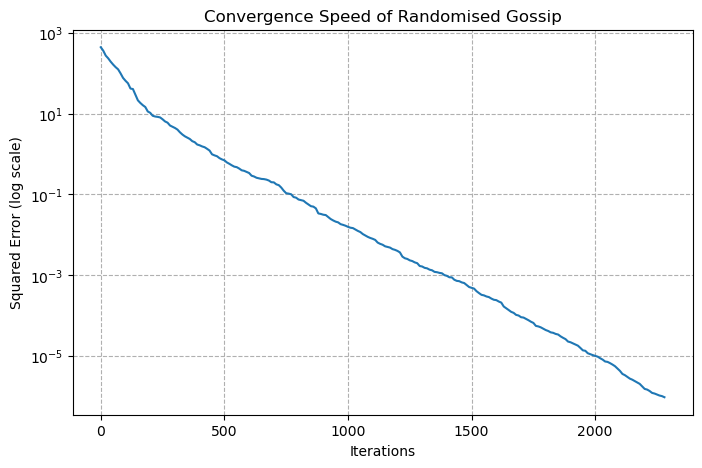

In [19]:
# convergence speed
# 绘制收敛速度图
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_rg['errors'])) * 10, history_rg['errors'])
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed of Randomised Gossip')
plt.grid(True, which="both", ls="--")
plt.show()

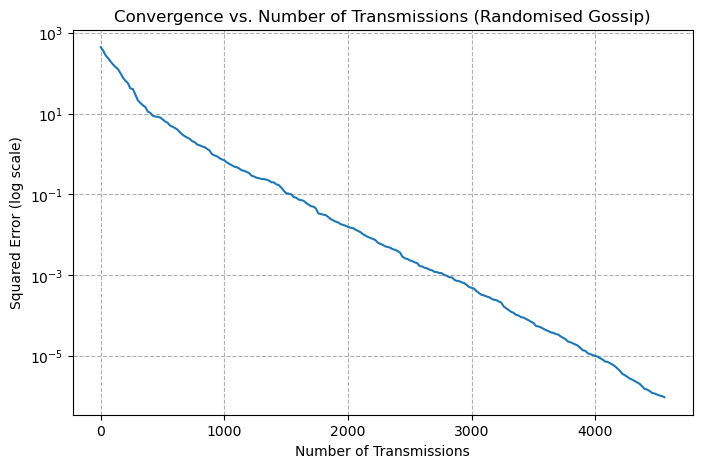

In [20]:
# number of transmissions
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_rg['errors'])) * 10 * 2, history_rg['errors'])
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence vs. Number of Transmissions (Randomised Gossip)')
plt.grid(True, which="both", ls="--")
plt.show()

### PDMM

In [ ]:
def pdmm_average_consensus(
        v,               # Local sensor readings a_i
        adj,             # Adjacency matrix (bool 2-D)
        c=1.0,           # PDMM tuning parameter c ≈ 1/ρ c不是大于0就行了吗
        is_unicast=True,  # 是否单向通信
        is_synchronous=True,  # 是否同步
        active_rate=1.0,  # 每次迭代中活跃节点的比例
        max_iter=5000,
        tol=1e-6,
        log_freq=10,
        verbose=False):
    """
    Synchronous PDMM for the average-consensus problem.

    Returns
    -------
    x : np.ndarray
        Consensus values at each node.
    history : dict
        'errors'          squared-error trace ‖x-avg‖² every log_freq iters
        'tx_curve'        cumulative number of scalar transmissions
        'transmissions'   final total transmissions
    """
    n       = len(v)
    deg     = np.sum(adj, axis=1)            # Node degree d_i
    avg     = v.mean()

    # ---------- Initialisation ----------
    # Directed edge set: (i, j) s.t. i ≠ j and adj[i, j] == True
    dir_edges = [(i, j) for i in range(n) for j in range(n)
                 if i != j and adj[i, j]]
    z   = {e: 0.0 for e in dir_edges}        # z_{i|j}
    x   = v.copy()

    # ---------- Logging ----------
    err_hist = [np.sum((x - avg) ** 2)]
    tx_hist  = [0]
    transmissions = 0
    # iterations = 0 # 这是个问题

    # ---------- Main loop ----------
    for k in range(1, max_iter):
        # according to is_synchronous, iterate over all nodes or just some random ones
        if is_synchronous:
            active_nodes = range(n)
        else:
            active_nodes = random.sample(range(n), int(active_rate * n))

        # 1) x-update
        y = {}
        for i in active_nodes:
            edges = [(i, j) for j in range(n) if adj[i, j] and i != j]
            if not edges:
                continue

            s_z = sum(z[edge] for edge in edges)
            x[i] = (v[i] - s_z) / (1 + c * deg[i])

            # 2) y-updates
            for edge in edges:
                y[edge] = z[edge] + 2 * c * x[i]    # y_{i|j}^{(k)}

            if is_unicast:
                # Unicast: send y_{i|j} to j
                transmissions += len(edges)
            else:
                # Broadcast: send x_{k} to j
                transmissions += 1

        # 3) z-updates
        for i in active_nodes:
            for j in range(n):
                if i != j and adj[i, j]:
                    z[(j, i)] = -y[(i, j)]          # z_{i|j}^{(k+1)}

        # Logging / convergence check
        if k % log_freq == 0:
            err = np.sum((x - avg) ** 2)
            err_hist.append(err)
            tx_hist.append(transmissions)
            if verbose:
                print(f"iter {k:5d} | err = {err:.3e}")
            if err < tol:
                break

    history = {
        'errors': err_hist,
        'tx_curve': tx_hist,
        'transmissions': tx_hist[-1],
        'iteration': k
    }
    
    return x, history

In [22]:
# ------------------ Run PDMM algorithm ------------------ 这段其实可以删,之前应该是用来测试用的
final_pdmm, history_pdmm = pdmm_average_consensus(init_values, adj_matrix)
print("Errors:", history_pdmm['errors'])
print("Length:", len(history_pdmm['errors']))

Errors: [443.9563904200792, 2923.4306431792315, 238.03749278768663, 19.988695882166816, 1.7944306598936477, 0.18023149618768344, 0.02083097398637806, 0.0027390678860818325, 0.0003184160878655298, 5.6106549368120705e-05, 1.6450944039363687e-05, 7.79279412873983e-06, 2.8172355854994734e-06, 8.484770859644192e-07]
Length: 14


In [23]:
# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_average_consensus(init_values, adj_matrix)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_avg = np.mean(final_values)
global_avg = np.mean(init_values)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors']) * 10}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Square error: {final_error:.8f}") # 没有mean


Algorithm completed!
Total iterations: 140
Total transmissions: 103220
Execution time: 0.0907 seconds
Final estimated average: 25.10384168
Global average: 25.10382558
Absolute error: 0.00001611
Square error: 0.00000085


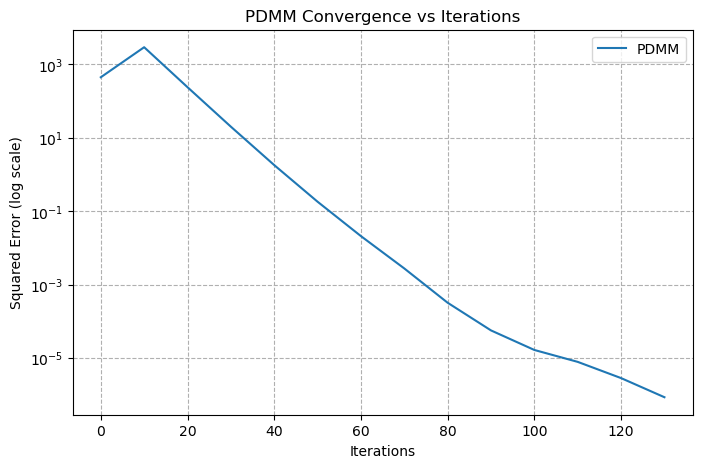

In [24]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])) * 10, history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

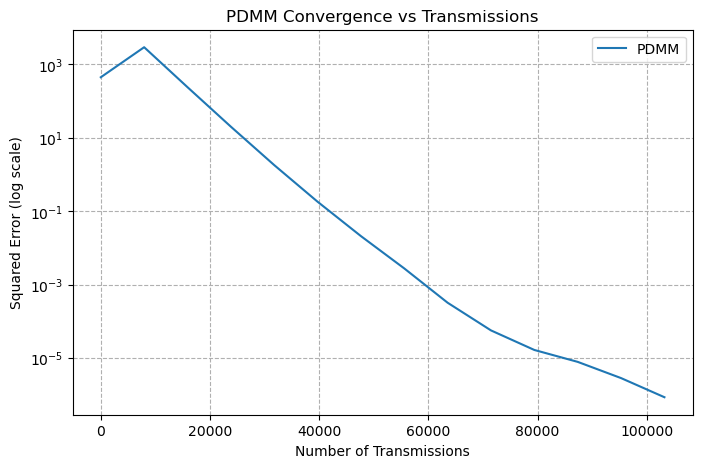

In [25]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

In [26]:
# ------------------ Output total number of transmissions ------------------
print("Total number of transmissions used by PDMM:", history_pdmm['transmissions'])

Total number of transmissions used by PDMM: 103220


### Comparison between RG and PDMM

In [27]:
# run 4 results of syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
pdmm_syn_unicast, history_pdmm_syn_unicast = pdmm_average_consensus(init_values, adj_matrix)
pdmm_asyn_unicast, history_pdmm_asyn_unicast = pdmm_average_consensus(
    init_values, adj_matrix, is_synchronous=False, active_rate=0.5)
pdmm_syn_broadcast, history_pdmm_syn_broadcast = pdmm_average_consensus(
    init_values, adj_matrix, is_unicast=False)
pdmm_asyn_broadcast, history_pdmm_asyn_broadcast = pdmm_average_consensus(
    init_values, adj_matrix, is_unicast=False, is_synchronous=False, active_rate=0.5)

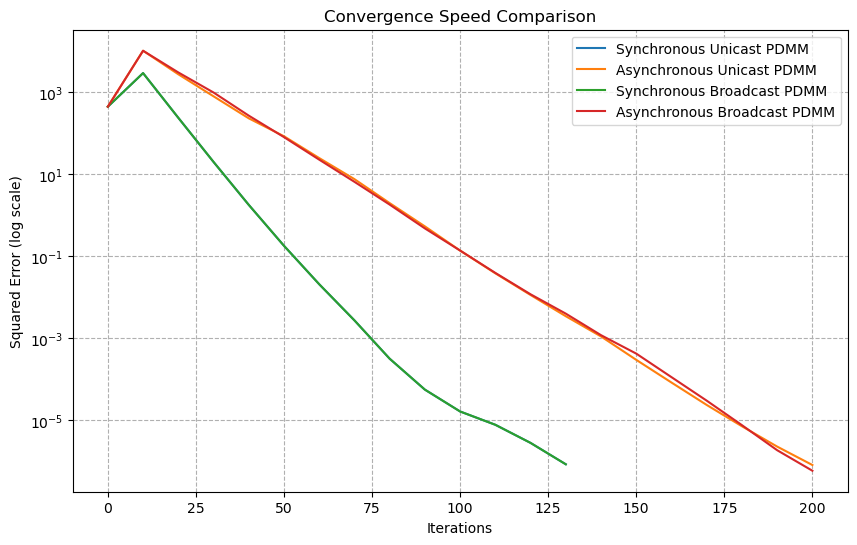

In [28]:
# generate image showing the squared error vs iteration
# the image has 5 lines, representing the results of syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_unicast['errors'])) * 10,
                history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')

# Asynchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_unicast['errors'])) * 10,
                history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

# Synchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_broadcast['errors'])) * 10,
                history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

# Asynchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_broadcast['errors'])) * 10,
                history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed Comparison')
plt.grid(True, which="both", ls="--")
plt.legend()
# plt.savefig('error_vs_iteration_comparison.png') # Save the figure
plt.show()

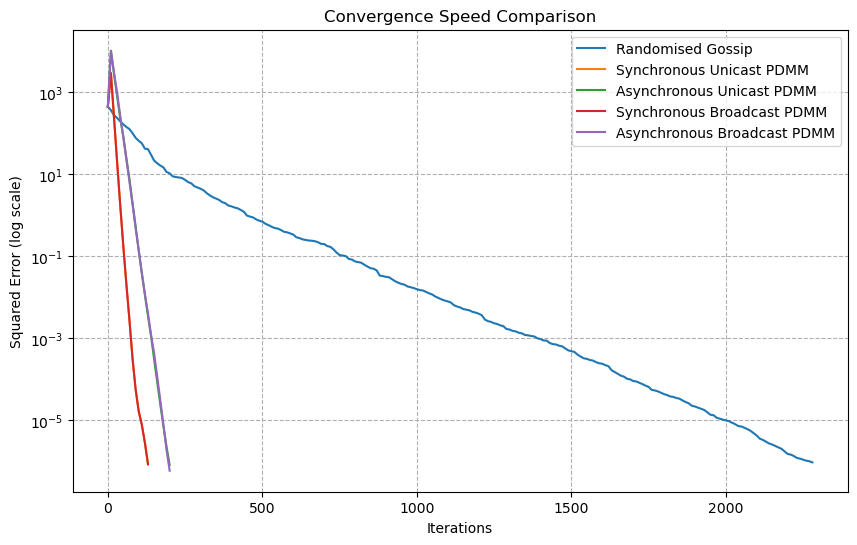

In [29]:
# generate image showing the squared error vs iteration
# the image has 5 lines, representing the results of rg, syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
plt.figure(figsize=(10, 6))

# Randomised Gossip
plt.semilogy(np.arange(0, len(history_rg['errors'])) * 10, history_rg['errors'], label='Randomised Gossip')

# Synchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_unicast['errors'])) * 10,
                history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')

# Asynchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_unicast['errors'])) * 10,
                history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

# Synchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_broadcast['errors'])) * 10,
                history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

# Asynchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_broadcast['errors'])) * 10,
                history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed Comparison')
plt.grid(True, which="both", ls="--")
plt.legend()
# plt.savefig('error_vs_iteration_comparison.png') # Save the figure
plt.show()

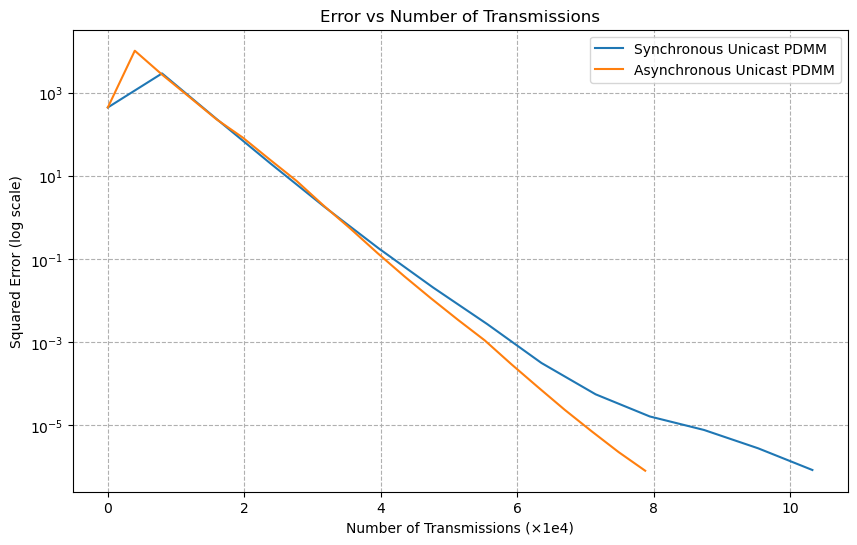

In [30]:
# generate image showing the squared error vs number of transmissions
# only the results of syn unicast pdmm, asyn unicast pdmm
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']) / 1e4, history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

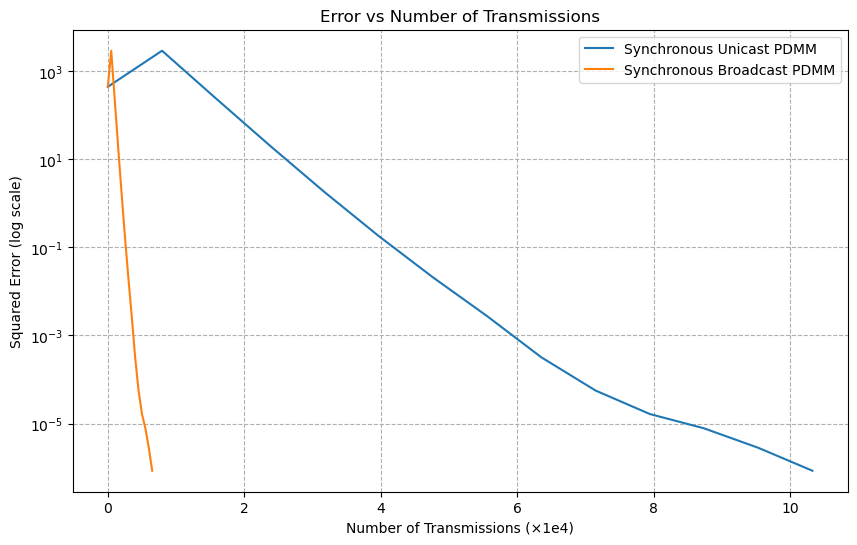

In [31]:
# generate image showing the squared error vs number of transmissions
# the image has 5 lines, only the results of syn unicast pdmm, syn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']) / 1e4, history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

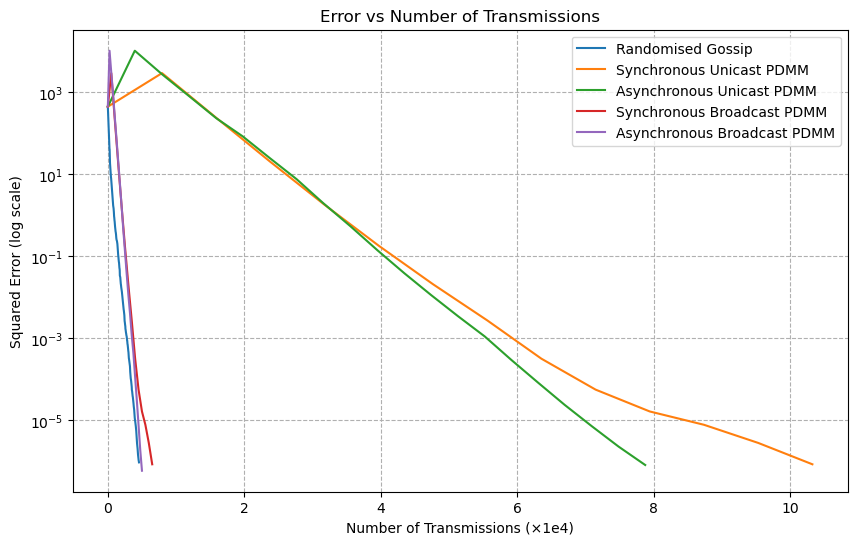

In [32]:
# generate image showing the squared error vs number of transmissions
# 横坐标改成x乘以10的4次方
plt.figure(figsize=(10, 6))
# Randomised Gossip
plt.semilogy(np.arange(0, len(history_rg['errors'])) * 10 * 2 / 1e4, history_rg['errors'], label='Randomised Gossip')
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']) / 1e4, history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']) / 1e4, history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')
# Asynchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_asyn_broadcast['tx_curve']) / 1e4, history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

## Q3 median

In [24]:
np.random.seed(42)
random.seed(42)

# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99

n = 51                   # Number of sensors
Comm_Radius = 50          # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix[j,k]:
            Graphs.add_edge(j, k)
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

# 初始值
init_values = np.random.uniform(10, 20, n)
global_avg = np.mean(init_values)
print(f"Global average: {global_avg:.4f}")

[[False False False ... False False  True]
 [False False False ...  True False False]
 [False False False ...  True  True  True]
 ...
 [False  True  True ... False False False]
 [False False  True ... False False False]
 [ True False  True ... False False False]]
Network connected: True
Number of edges: 594
Global average: 14.8117


In [ ]:
def error_calculation(n, sensor_values, x):
    if n%2 == 1:  # number of nodes is odd
        median_val = np.median(sensor_values)
        median_min = median_val * np.ones(n)
        median_max = median_min.copy()
        error_iter = np.linalg.norm(x - median_max) / median_max[0]
    else:
        k1, k2 = n // 2 - 1, n // 2
        median_min = np.partition(sensor_values, k1)[k1] * np.ones(n)
        median_max = np.partition(sensor_values, k2)[k2] * np.ones(n)
        within = (x >= median_min) & (x <= median_max)
        err_vec = np.where(
            within,
            0,
            np.minimum(np.abs(x - median_min), np.abs(x - median_max))
        )
        error_iter = np.linalg.norm(err_vec) / (0.5 * (median_min[0] + median_max[0]))
    return error_iter


def pdmm_median(adj, sensor_values, c, broadcast = False, num_iter = 5000, active_ratio = 1.0):
    # Initialization
    n = len(adj[0])
    x = sensor_values.copy()
    transmissions = [0]
    transmission = 0
    error = []

    # Calculate median & errors
    error_iter = error_calculation(n, sensor_values, x)
    error.append(error_iter)

    # Initialize y & z
    y, z, z_temp = {}, {}, {}
    dir_edges = [(i, j) for i in range(n) for j in range(n)
                 if i != j and adj[i, j]]
    y = {e: 0.0 for e in dir_edges}
    z = y.copy()
    z_pre = {(j,i): 0.0 for (i,j) in dir_edges}

    # Iteration
    iter = 0
    for i in range(num_iter + 1):

     # Random choose the activated nodes
        active_nodes = np.random.choice(range(n), int(active_ratio * n), replace=False)

        # Update x & y
        for i in active_nodes:
            edges_i = [j for (k, j) in dir_edges if k == i]
            sum_z = 0
            for j in edges_i:
                A = 1 if i<j else -1
                sum_z += A * z[(i, j)]

            # Update x[i]
            denominator = c * len(edges_i)
            bound_low = (-1 - sum_z) / denominator
            bound_high = (1 - sum_z) / denominator
            s_i = sensor_values[i]
            if bound_low > sensor_values[i]:
                x[i] = bound_low
            elif bound_high < sensor_values[i]:
                x[i] = bound_high
            else:
                x[i] = s_i
            for j in edges_i:
                A = 1 if i < j else -1
                y[(i, j)] = z[(i, j)] + 2 * c * A * x[i]


        # Update z
        z_tmp = z.copy()
        z_pre_tmp = z_pre.copy()
        for i in active_nodes:
            edges_i = [j for (k, j) in dir_edges if k == i]
            for j in edges_i:
                A = 1 if i < j else -1
                if broadcast:
                    # Update z
                    y_tmp = z_pre_tmp[(i, j)] + 2 * c * A * x[i]
                    z[(j, i)] = 0.5 * z_tmp[(j, i)] + 0.5 * y_tmp
                    z_pre[(j, i)] = 0.5 * z_pre_tmp[(j, i)]+ 0.5 * y[(i, j)]
                else:
                    z[(j, i)] = 0.5 * z_tmp[(j, i)] + 0.5 * y[(i, j)]
                    transmission += 1
            if broadcast:
                transmission += 1

        # Error update
        error_iter = error_calculation(n, sensor_values, x)
        error.append(error_iter)
        transmissions.append(transmission)
        iter += 1

    return error, transmissions, x

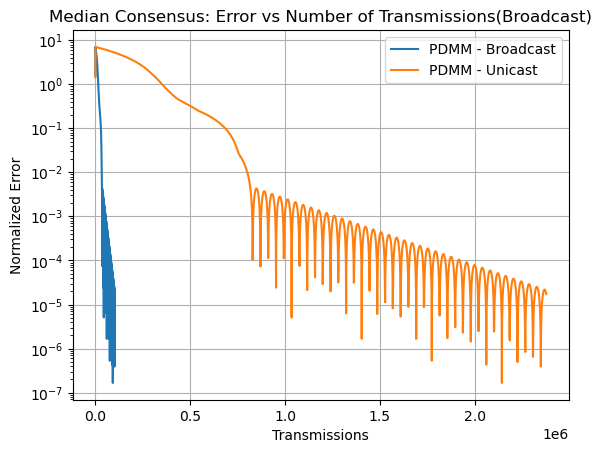

In [ ]:
error_1, transmissions_1, x_1 = pdmm_median(adj_matrix, init_values, 1, broadcast = True, num_iter = 2000, active_ratio = 1)
error_2, transmissions_2, x_2 = pdmm_median(adj_matrix, init_values, 1, broadcast = False, num_iter = 2000, active_ratio = 1)

fig = plt.figure()
plt.semilogy(transmissions_1, error_1, label=f'PDMM - Broadcast')
plt.semilogy(transmissions_2, error_2, label=f'PDMM - Unicast')

plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel("Normalized Error")

plt.title("Median Consensus: Error vs Number of Transmissions(Broadcast)")
plt.legend()
plt.show()


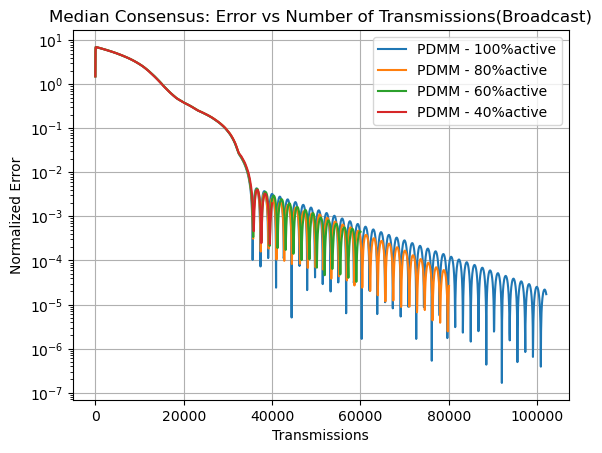

In [ ]:
error_1, transmissions_1, x_1 = pdmm_median(adj_matrix, init_values, 1, broadcast = True, num_iter = 2000, active_ratio = 1)
error_2, transmissions_2, x_2 = pdmm_median(adj_matrix, init_values, 1, broadcast = True, num_iter = 2000, active_ratio = 0.8)
error_3, transmissions_3, x_3 = pdmm_median(adj_matrix, init_values, 1, broadcast = True, num_iter = 2000, active_ratio = 0.6)
error_4, transmissions_4, x_4 = pdmm_median(adj_matrix, init_values, 1, broadcast = True, num_iter = 2000, active_ratio = 0.4)
fig = plt.figure()
plt.semilogy(transmissions_1, error_1, label=f'PDMM - 100%active')
plt.semilogy(transmissions_2, error_2, label=f'PDMM - 80%active')
plt.semilogy(transmissions_3, error_3, label=f'PDMM - 60%active')
plt.semilogy(transmissions_4, error_4, label=f'PDMM - 40%active')
plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel("Normalized Error")

plt.title("Median Consensus: Error vs Number of Transmissions(Broadcast)")
plt.legend()
plt.show()



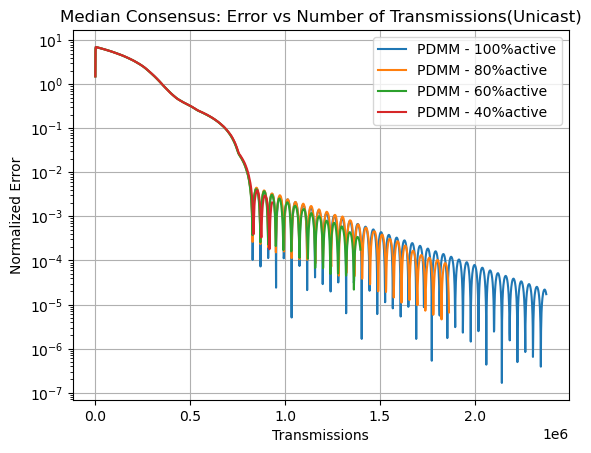

In [ ]:
error_1, transmissions_1, _ = pdmm_median(adj_matrix, init_values, 1, broadcast = False, num_iter = 2000, active_ratio = 1)
error_2, transmissions_2, _ = pdmm_median(adj_matrix, init_values, 1, broadcast = False, num_iter = 2000, active_ratio = 0.8)
error_3, transmissions_3, _ = pdmm_median(adj_matrix, init_values, 1, broadcast = False, num_iter = 2000, active_ratio = 0.6)
error_4, transmissions_4, _ = pdmm_median(adj_matrix, init_values, 1, broadcast = False, num_iter = 2000, active_ratio = 0.4)
fig = plt.figure()
plt.semilogy(transmissions_1, error_1, label=f'PDMM - 100%active')
plt.semilogy(transmissions_2, error_2, label=f'PDMM - 80%active')
plt.semilogy(transmissions_3, error_3, label=f'PDMM - 60%active')
plt.semilogy(transmissions_4, error_4, label=f'PDMM - 40%active')
plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel("Normalized Error")

plt.title("Median Consensus: Error vs Number of Transmissions(Unicast)")
plt.legend()
plt.show()


## Q3 new

In [37]:
def pdmm_median_consensus(
        v,               # Local sensor readings a_i
        adj,             # Adjacency matrix (bool 2-D)
        c=1.0,           # PDMM tuning parameter c ≈ 1/ρ c不是大于0就行了吗
        is_unicast=True,  # 是否单向通信
        is_synchronous=True,  # 是否同步
        active_rate=1.0,  # 每次迭代中活跃节点的比例
        max_iter=5000,
        tol=1e-6,
        log_freq=10,
        verbose=False):
    """
    Synchronous PDMM for the average-consensus problem.

    Returns
    -------
    x : np.ndarray
        Consensus values at each node.
    history : dict
        'errors'          squared-error trace ‖x-median‖² every log_freq iters
        'tx_curve'        cumulative number of scalar transmissions
        'transmissions'   final total transmissions
    """
    n = len(v)
    deg = np.sum(adj, axis=1)            # Node degree d_i
    median = np.median(v)

    # ---------- Initialisation ----------
    # Directed edge set: (i, j) s.t. i ≠ j and adj[i, j] == True
    dir_edges = [(i, j) for i in range(n) for j in range(n)
                 if i != j and adj[i, j]]
    z = {e: 0.0 for e in dir_edges}        # z_{i|j}
    x = v.copy()

    # ---------- Logging ----------
    err_hist = [np.sum((x - median) ** 2)]
    abs_err_hist = [np.linalg.norm(x - median) / median]
    tx_hist  = [0]
    transmissions = 0
    # iterations = 0 # 这是个问题

    # ---------- Main loop ----------
    for k in range(1, max_iter):
        # according to is_synchronous, iterate over all nodes or just some random ones
        if is_synchronous:
            active_nodes = range(n)
        else:
            active_nodes = random.sample(range(n), int(active_rate * n))

        y = {}
        for i in active_nodes:
            neighbors = [j for (k, j) in dir_edges if k == i]
            if not neighbors:
                continue
            
            s_z = 0
            for j in neighbors:
                A = 1 if i < j else -1
                s_z += A * z[(i, j)]
            
            # 1) x-update
            denominator = c * deg[i]
            bound_low = (-1 - s_z) / denominator
            bound_high = (1 - s_z) / denominator
            if bound_low > v[i]:
                x[i] = bound_low
            elif bound_high < v[i]:
                x[i] = bound_high
            else:
                x[i] = v[i]

            # 2) y-updates
            for j in neighbors:
                A = 1 if i < j else -1
                y[(i, j)] = z[(i, j)] + 2 * c * A * x[i]

            if is_unicast:
                # Unicast: send y_{i|j} to j
                transmissions += len(neighbors)
            else:
                # Broadcast: send x_{k} to j
                transmissions += 1

        # 3) z-updates
        for i in active_nodes:
            for j in range(n):
                if i != j and adj[i, j]:
                    z[(j, i)] = 0.5 * z[(j, i)] + 0.5 * y[(i, j)] # z_{i|j}^{(k+1)}

        # Logging / convergence check
        # if k % log_freq == 0:
        err = np.sum((x - median) ** 2)
        err_hist.append(err)
        abs_err = np.linalg.norm(x - median) / median
        abs_err_hist.append(abs_err)
        tx_hist.append(transmissions)
        if verbose:
            print(f"iter {k:5d} | err = {err:.3e}")
        if abs_err < tol:
            break

    history = {
        'errors': err_hist,
        'abs_errors': abs_err_hist,
        'tx_curve': tx_hist,
        'transmissions': tx_hist[-1],
        'iteration': k
    }
    
    return x, history

In [ ]:
# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_median_consensus(init_values, adj_matrix)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_median = np.median(final_values)
global_median = np.median(init_values)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors'])}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_median:.8f}")
print(f"Global average: {global_median:.8f}")
print(f"Absolute error: {abs(final_median - global_median):.8f}")
print(f"Square error: {final_error:.8f}") # 没有mean


Algorithm completed!
Total iterations: 14940
Total transmissions: 1773684
Execution time: 4.9294 seconds
Final estimated average: 14.17411110
Global average: 14.17411003
Absolute error: 0.00000107
Square error: 0.00000000


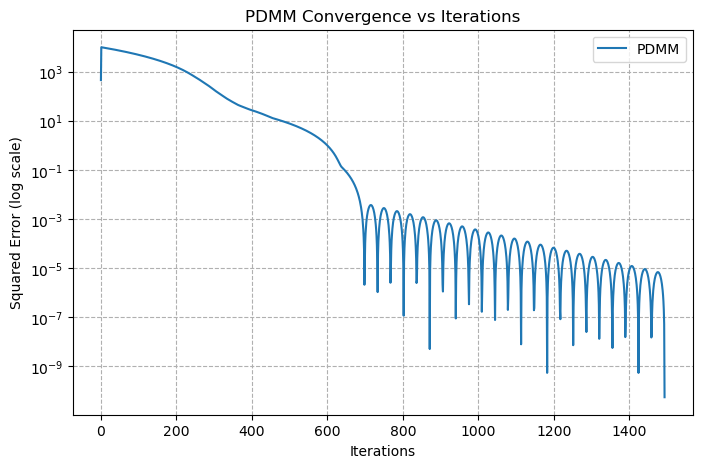

In [39]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])), history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

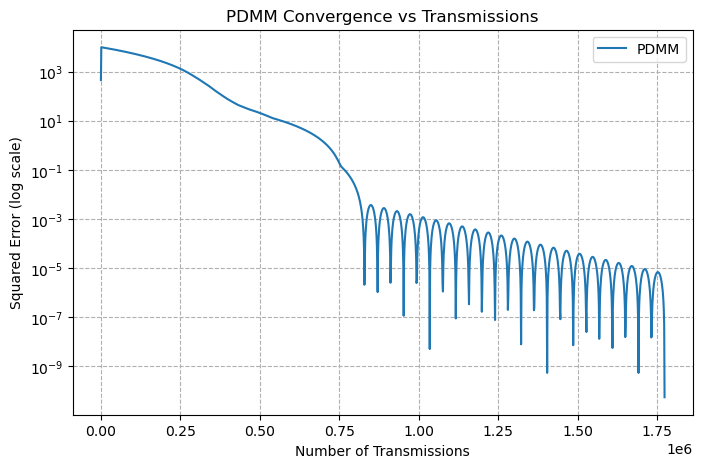

In [40]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

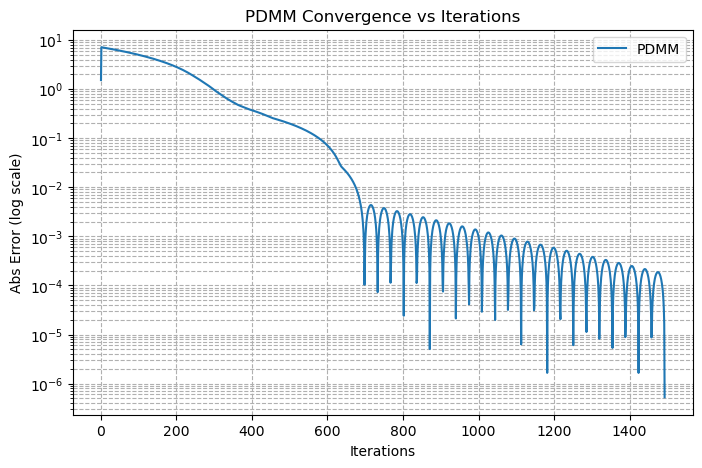

In [41]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['abs_errors'])), history_pdmm['abs_errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Abs Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

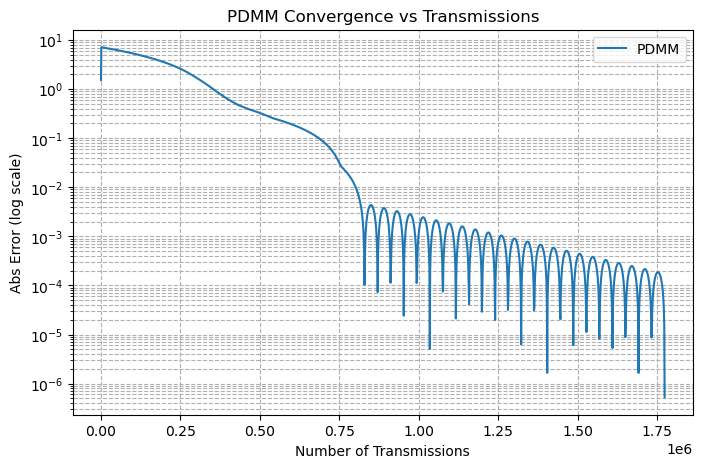

In [42]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['abs_errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Abs Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()